## MNIST CNN

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *

### Data

In [3]:
path = untar_data(URLs.MNIST)

In [4]:
path.ls()

[PosixPath('/storage/mnist_png/training'),
 PosixPath('/storage/mnist_png/testing')]

In [5]:
il = ImageList.from_folder(path, convert_mode='L')

In [6]:
len(il.items)
il.items[0]

PosixPath('/storage/mnist_png/training/7/52587.png')

In [7]:
defaults.cmap='binary'

In [8]:
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /storage/mnist_png

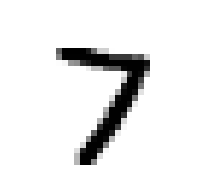

In [9]:
il[0].show()

In [10]:
sd = il.split_by_folder(train='training', valid='testing')

In [11]:
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /storage/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /storage/mnist_png;

Test: None

In [12]:
(path/'training').ls()

[PosixPath('/storage/mnist_png/training/7'),
 PosixPath('/storage/mnist_png/training/4'),
 PosixPath('/storage/mnist_png/training/1'),
 PosixPath('/storage/mnist_png/training/2'),
 PosixPath('/storage/mnist_png/training/9'),
 PosixPath('/storage/mnist_png/training/3'),
 PosixPath('/storage/mnist_png/training/8'),
 PosixPath('/storage/mnist_png/training/5'),
 PosixPath('/storage/mnist_png/training/0'),
 PosixPath('/storage/mnist_png/training/6')]

In [13]:
ll = sd.label_from_folder()

In [14]:
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /storage/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
7,7,7,7,7
Path: /storage/mnist_png;

Test: None

In [15]:
x,y = ll.train[0]

7 torch.Size([1, 28, 28])


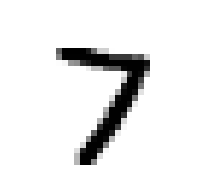

In [16]:
x.show()
print(y,x.shape)

In [17]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [18]:
ll = ll.transform(tfms)

In [19]:
bs = 128

In [20]:
# not using imagenet_stats because not using pretrained model
data = ll.databunch(bs=bs).normalize()

In [21]:
x,y = data.train_ds[0]

7


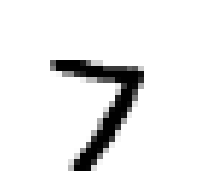

In [22]:
x.show()
print(y)

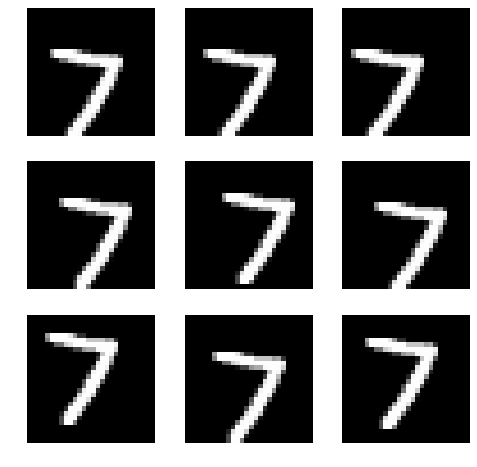

In [23]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [24]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

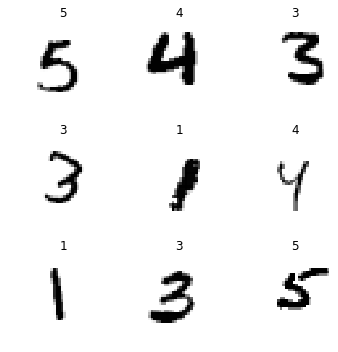

In [25]:
data.show_batch(rows=3, figsize=(5,5))

### Basic CNN with batchnorm

In [26]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [27]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [28]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [29]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          80         True      
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,168      True      
______________________________________________________________________
BatchNorm2d          [16, 7, 7]           32         True      
______________________________________________________________________
ReLU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,640      True      
___________________________________________________

In [30]:
xb = xb.cuda()

In [31]:
model(xb).shape

torch.Size([128, 10])

In [32]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


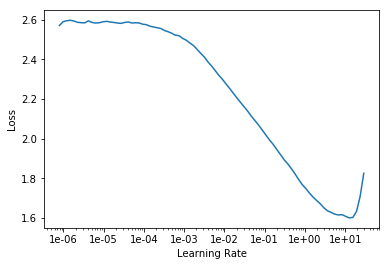

In [33]:
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.226179,0.146976,0.952500,00:20
1,0.136340,0.078812,0.974200,00:14
2,0.076460,0.045128,0.985600,00:09


### Refactor

In [35]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [36]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [37]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [38]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.231798,0.141095,0.955900,00:07
1,0.194983,0.135913,0.953800,00:07
2,0.160789,0.188038,0.939400,00:07
3,0.135041,0.133747,0.957300,00:07
4,0.122409,0.124107,0.960700,00:07
5,0.102900,0.058608,0.982700,00:07
6,0.079138,0.062806,0.979900,00:07
7,0.060033,0.034962,0.989300,00:07
8,0.043063,0.029464,0.990600,00:07
9,0.042461,0.027022,0.991300,00:07


### Resnet-ish

In [39]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [40]:
help(res_block)

Help on function res_block in module fastai.layers:

res_block(nf, dense:bool=False, norm_type:Union[fastai.layers.NormType, NoneType]=<NormType.Batch: 1>, bottle:bool=False, **conv_kwargs)
    Resnet block of `nf` features. `conv_kwargs` are passed to `conv_layer`.



In [41]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [42]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [43]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [44]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


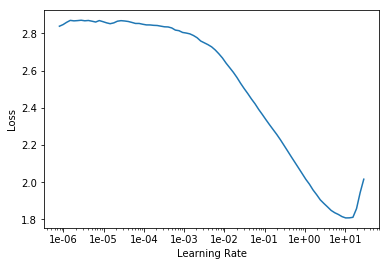

In [45]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [46]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy,time
0,0.198855,0.121257,0.966900,00:15
1,0.134798,0.135394,0.958800,00:10
2,0.102652,0.106483,0.966600,00:10
3,0.092006,0.124430,0.961600,00:10
4,0.066738,0.058544,0.982400,00:10
5,0.060104,0.315417,0.906600,00:10
6,0.056945,0.060446,0.982000,00:10
7,0.042581,0.097686,0.967900,00:10
8,0.037232,0.021701,0.992900,00:10
9,0.026701,0.020710,0.993000,00:10


In [47]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
______________________________________________________________________
ReLU                 [8, 14, 14]          0          False     
______________________________________________________________________
BatchNorm2d          [8, 14, 14]          16         True      
______________________________________________________________________
Conv2d               [8, 14, 14]          576        True      
___________________________________________________

## fin